# **Importación de librerías**

In [164]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,auc, plot_roc_curve, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from itertools import product
from scipy.spatial import distance
from sklearn.decomposition import PCA
import time

# **Limpieza de datos**

In [169]:
df = pd.read_csv('https://raw.githubusercontent.com/JulianaCadavid/proyecto_simul/main/data_base/CTG.csv')

**Se eliminan columnas irrelevantes**

In [170]:
df=df.drop(['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE', 'DR', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'],axis=1)

**Numero de Datos faltantes (N/A) por columna**

In [171]:
k = df.isna().sum()
k[k!=0]

LB          3
AC          3
FM          2
UC          2
ASTV        2
MSTV        2
ALTV        2
MLTV        2
DL          1
DS          1
DP          1
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
CLASS       3
NSP         3
dtype: int64

**Se eliminan los Datos faltantes (N/A) por columna**

In [172]:
df = df.dropna()

In [173]:
k = df.isna().sum()
k[k!=0]

Series([], dtype: int64)

In [174]:
df.isnull().sum()

LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
CLASS       0
NSP         0
dtype: int64

In [175]:
df['MSTV'] = df['MSTV'].str.replace(',', '.')
df['MLTV'] = df['MLTV'].str.replace(',', '.')
df[["MSTV", "MLTV"]] = df[["MSTV", "MLTV"]].apply(pd.to_numeric)

**Desbalanceo**

In [176]:
def class_frequency(array):
    """It measures the frequence of each class in the array. """
    val = array.value_counts()
    class_freq = val/len(array)
    idx = class_freq.index
    
    for i, freq in np.ndenumerate(class_freq):
        print("The frequency of class {0} is {1:.3}".format(idx[i], freq))
    
    return class_freq

In [177]:
fs_labels = df['NSP']

In [178]:
_ = class_frequency(fs_labels)

The frequency of class 1.0 is 0.778
The frequency of class 2.0 is 0.139
The frequency of class 3.0 is 0.0828


In [179]:
# the value of the class of normal cases is set to 0, (absence of disease)
idxs = fs_labels[fs_labels == 1]
fs_labels[idxs.index] = 0

# suspicious and pathologic exams are merged in one class with positive value (presence or suspect of presence of disease)
idxs = fs_labels[fs_labels == 2]
fs_labels[idxs.index] = 1

idxs = fs_labels[fs_labels == 3]
fs_labels[idxs.index] = 1

**Obtencion X y Y**

In [180]:
def Takex_y(d):
  x =d.iloc[:,0:-1].values
  y= d.iloc[:,d.shape[1]-1].values
  return x,y
X,Y = Takex_y(df)

In [181]:
print("X",X,"Y",Y)

X [[120.   0.   0. ...  73.   1.   9.]
 [132.   4.   0. ...  12.   0.   6.]
 [133.   2.   0. ...  13.   0.   6.]
 ...
 [140.   1.   0. ...   4.   1.   5.]
 [140.   1.   0. ...   4.   1.   5.]
 [142.   1.   1. ...   1.   0.   1.]] Y [1. 0. 0. ... 1. 1. 0.]


# **Balanceo de clases**

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0.0: 1154, 1.0: 334})
Testing target statistics: Counter({0.0: 501, 1.0: 137})


## **Sobremuestreo**

In [183]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0.0: 1154, 1.0: 1154})
Testing target statistics: Counter({0.0: 501, 1.0: 137})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# **Análisis discriminante Cuadrático**

In [184]:
def experimentar_QDA(X,Y,regParams):

    #Curva de ROC
    fig, ax = plt.subplots()
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    mean_fpr = np.linspace(0, 1, 100)
   
    
    #Metodología de Validación 
    skf = StratifiedKFold()
    resultados = pd.DataFrame()
    idx = 0

    EficienciaTrain = []
    EficienciaVal = []

    for reg_param in regParams:
      tprs = []
      for train, test in skf.split(X, Y):
          Xtrain = X[train,:]
          Ytrain = Y[train]
          Xtest = X[test,:]
          Ytest = Y[test]

      
          #Entrenamiento del modelo
          modelo= QuadraticDiscriminantAnalysis(reg_param=reg_param)
          modelo =modelo.fit(Xtrain,Ytrain)
          #Predición con las muestras de entrenamiento
          Ytrain_pred =  modelo.predict(Xtrain)
          #Predicción con las muestras de prueba
          Yest = modelo.predict(Xtest)
          
          #Evalución de las predicciones con el conjunto de test
          EficienciaTrain.append(balanced_accuracy_score(y_true = Ytrain, y_pred = Ytrain_pred))
          EficienciaVal.append(balanced_accuracy_score( y_true= Ytest, y_pred=Yest))


          #Curva de ROC                           
          viz = plot_roc_curve(modelo, Xtrain, Ytrain,
                      label="", alpha=0.0,ax=ax)
          
          interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
          interp_tpr[0] = 0.0
          tprs.append(interp_tpr)
          
     

      #Obtención de resultados
      resultados.loc[idx,'Param reg'] = reg_param
      resultados.loc[idx,'Accuracy train'] = np.mean(EficienciaTrain)
      resultados.loc[idx,'Std  train'] = np.std(EficienciaTrain)
      resultados.loc[idx,'Accuracy test'] =np.mean(EficienciaVal)
      resultados.loc[idx,'Std test'] = np.std(EficienciaVal)
      idx+=1


      mean_tpr = np.mean(tprs, axis=0)
      mean_tpr[-1] = 1.0
      mean_auc = auc(mean_fpr, mean_tpr)
      ax.plot(mean_fpr, mean_tpr,
          label="Param reg: "+str(reg_param)+", AUC: "+str(mean_auc)[0:4])

      ax.set(xlim=[-0.1, 1.1], ylim=[-0.1, 1.1],title="ROC CURVE")
          

    plt.show()    
    return (resultados)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

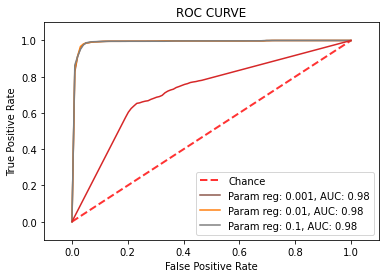

In [185]:
resultsQDA= experimentar_QDA(X_res,y_res, [0.001, 0.01, 0.1, 1])

In [186]:
resultsQDA

,Param reg,Accuracy train,Std train,Accuracy test,Std test
0,0.001,0.956674,0.003116,0.947551,0.014628
1,0.010,0.959110,0.004231,0.950370,0.014221
2,0.100,0.959995,0.004061,0.950877,0.014130
3,1.000,0.897585,0.108200,0.889508,0.107017


# **Ventana de Parzen (Metodo kernel)**

In [187]:
def experimentar_Parzen (X, Y, w):
    
    #Metodología de Validación
    skf = StratifiedKFold()
    resultados = pd.DataFrame()
    idx = 0

    for h in w:

        accu_temp = []
       

        mean_fpr = np.linspace(0, 1, 100)

        for train, test in skf.split(X, Y):

            Xtrain = X[train,:]
            Ytrain = Y[train]
            Xtest = X[test,:]
            Ytest = Y[test]

            scaler = StandardScaler()
            scaler.fit(Xtrain)
            Xtrain = scaler.transform(Xtrain)
            Xtest = scaler.transform(Xtest)

            fds_matrix = np.zeros((Xtest.shape[0], 2))
            
            estimators = []
            for c in [0,1]:
              m = KernelDensity(bandwidth=h).fit(Xtrain[Ytrain==c])
              estimators.append(m)
            i = 0

            for estimator in estimators:
              
              fds_matrix[:,i]=estimator.score_samples(Xtest)
              i=i+1
            
           
            Yest=np.argmax(fds_matrix,1)

            
            accu_temp.append(balanced_accuracy_score(y_true=Ytest,y_pred=Yest))

        #Obtención resultados    
        resultados.loc[idx,'Ancho de ventana '] = h 
        resultados.loc[idx,'Accuracy Test'] = np.mean(accu_temp)
        resultados.loc[idx,'Std'] = np.std(accu_temp)
        idx+=1
    return (resultados)

In [188]:
experimentos_parzen=experimentar_Parzen(X_res,y_res,w=[0.1,0.5,1,2,3,5,6,10,50])
experimentos_parzen

,Ancho de ventana,Accuracy Test,Std
0,0.1,0.924205,0.034759
1,0.5,0.989597,0.003983
2,1.0,0.989159,0.005504
3,2.0,0.949729,0.014015
4,3.0,0.903796,0.013635
5,5.0,0.851387,0.012372
6,6.0,0.822795,0.015272
7,10.0,0.776861,0.017097
8,50.0,0.730917,0.016441


# **Gradient Boosting Tree**

In [189]:
def experimentar_Gbt(num_trees, X, Y, extraccion):

   
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    #Metodología de Validación
    skf = StratifiedKFold()
    resultados = pd.DataFrame()

    
    idx = 0
    for trees in num_trees:
        
        AccuTrain = []
        AccuVal = []
        tprs = []

        
        mean_fpr = np.linspace(0, 1, 100)

        i = 1
        for train, test in skf.split(X, Y):
            Xtrain = X[train,:]
            Ytrain = Y[train]
            Xtest = X[test,:]
            Ytest = Y[test]
            #Entrenamiento del modelo
            modelo= GradientBoostingClassifier(n_estimators= trees)
            modelo =modelo.fit(Xtrain,Ytrain)
            #Predición con las muestras de entrenamiento
            Ytrain_pred =  modelo.predict(Xtrain)
            #Predición con las muestras de prueba
            Yest = modelo.predict(Xtest)

            if extraccion:
                  pca = PCA(n_components=14)
                  Xtrain = pca.fit_transform(X= Xtrain)
                  Xtest = pca.transform(X= Xtest)
            
            
            #Curva de ROC
            viz = plot_roc_curve(modelo, Xtrain, Ytrain,
                         label="", alpha=0.0,ax=ax)
            
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
            i=i+1


            AccuTrain.append(balanced_accuracy_score(y_true=Ytrain,y_pred=Ytrain_pred))
            AccuVal.append(balanced_accuracy_score(y_true=Ytest,y_pred=Yest))

        resultados.loc[idx,'Número de árboles'] = trees
        resultados.loc[idx,'Accuracy Train'] = np.mean(AccuTrain)
        resultados.loc[idx,'Std Train'] = np.std(AccuTrain)
        resultados.loc[idx,'Accuracy Test'] =np.mean(AccuVal)
        resultados.loc[idx,'Std Test'] = np.std(AccuVal)   
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        ax.plot(mean_fpr, mean_tpr,
                label="Trees: "+str(trees)+", AUC: "+str(mean_auc)[0:4])
       
        ax.set(xlim=[-0.1, 1.1], ylim=[-0.1, 1.1],
              title="ROC CURVE")
        
         

        idx= idx +1
    ax.legend(loc="lower right")
    plt.show()   
    return (resultados)

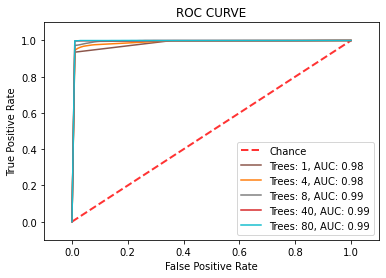

In [190]:
resultadosGbt = experimentar_Gbt([1,4,8,40,80],X_res, y_res, False)

In [191]:
resultadosGbt

,Número de árboles,Accuracy Train,Std Train,Accuracy Test,Std Test
0,1.0,0.965771,0.001623,0.965773,0.006481
1,4.0,0.965880,0.001494,0.964474,0.005226
2,8.0,0.976927,0.005128,0.974446,0.009217
3,40.0,0.993826,0.001168,0.989170,0.003061
4,80.0,0.997400,0.000405,0.996531,0.001734


# **Redes Neuronales Artificiales**

In [192]:
def experimentar_Mlp(X,Y, num_hidden_layers, num_neurons,extraccion):

    #Curva de ROC
    fig, ax = plt.subplots()
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    mean_fpr = np.linspace(0, 1, 100)
    
    
    #Metodología de validación
    folds= 4
    skf = StratifiedKFold(n_splits=folds)
    resultados = pd.DataFrame()
    idx = 0
    for hidden_layers in num_hidden_layers:
        for neurons in num_neurons:
            Error = np.zeros(folds)
            ErrorTrain = np.zeros(folds)
            tprs = []

            for j, (train, test) in enumerate(skf.split(X, Y)):

                
                Xtrain= X[train,:]
                Ytrain = Y[train]
                Xtest = X[test, :]
                Ytest = Y[test]
                scaler = StandardScaler().fit(X= Xtrain)       
                Xtrain = scaler.transform(Xtrain)
                Xtest = scaler.transform(Xtest)

                     
                if extraccion:
                  pca = PCA(n_components=6)
                  Xtrain = pca.fit_transform(X= Xtrain)
                  Xtest = pca.transform(X= Xtest)





                hidden_layer_sizes = tuple(hidden_layers*[neurons])

                mlp = MLPClassifier(activation='logistic',hidden_layer_sizes= hidden_layer_sizes, max_iter=1000)
 
                mlp =mlp.fit(X=Xtrain,y=Ytrain)
              

                Yest = mlp.predict(Xtest)
                YestTrain = mlp.predict(Xtrain)
        
                #ROC                         
                viz = plot_roc_curve(mlp, Xtrain, Ytrain,
                            label="", alpha=0.0,ax=ax)
                
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                
                


                Error[j] =balanced_accuracy_score(y_true= Ytest, y_pred= Yest)
                ErrorTrain[j] =balanced_accuracy_score(y_true= Ytrain, y_pred= YestTrain)
        
            #Obtención de resultados
            resultados.loc[idx,'Número de capas ocultas'] = hidden_layers
            resultados.loc[idx,'Número de neuronas'] = neurons 
            resultados.loc[idx,'Accuracy Train'] = np.mean(ErrorTrain)
            resultados.loc[idx,'Std Train'] = np.std(ErrorTrain)
            resultados.loc[idx,'Accuracy Test'] = np.mean(Error)
            resultados.loc[idx,'Std Test'] = np.std(Error)
            idx+=1

            #ROC
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            ax.plot(mean_fpr, mean_tpr,
                label="Capas ocultas: "+str(hidden_layers)+", Neuronas: "+str(neurons)+", AUC: "+str(mean_auc)[0:4])
       
            ax.set(xlim=[-0.1, 1.1], ylim=[-0.1, 1.1],title="ROC CURVE")
             
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    return (resultados)

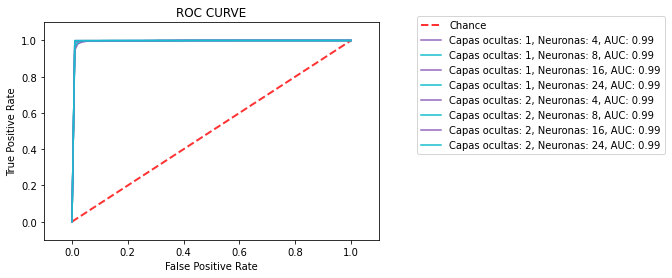

In [193]:
resultadosMlp = experimentar_Mlp(X_res,y_res, [1,2], [4,8,16,24],False)


In [194]:
resultadosMlp

,Número de capas ocultas,Número de neuronas,Accuracy Train,Std Train,Accuracy Test,Std Test
0,1.0,4.0,0.979493,0.001709,0.974000,0.006360
1,1.0,8.0,0.984546,0.002287,0.976172,0.007290
2,1.0,16.0,0.990612,0.003353,0.980937,0.003877
3,1.0,24.0,0.992635,0.001316,0.983100,0.002256
4,2.0,4.0,0.992489,0.001684,0.982667,0.005050
5,2.0,8.0,0.995523,0.000855,0.987428,0.001897
6,2.0,16.0,0.997256,0.000480,0.989166,0.002250
7,2.0,24.0,0.997689,0.000408,0.990028,0.002846


# **Máquina de soporte vectorial**

In [195]:
def experimentar_SVC(x, y, kernels, gammas,params_reg,extraccion):

    #Metodología de validación
    idx = 0
    kf = StratifiedKFold(n_splits=4)
    # Combinación de elementos de kernel, gamma y parámetro de regularización
    kernels_gammas_regs = list(product(kernels, gammas, params_reg))
    resultados = pd.DataFrame()

    #Curva ROC
    fig, ax = plt.subplots()
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    mean_fpr = np.linspace(0, 1, 100)
    

    
    for params in kernels_gammas_regs:
        kernel, gamma, param_reg = params
        
        errores_train = []
        errores_test = []
        pct_support_vectors = []

        tprs = []

        for train_index, test_index in kf.split(x,y):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]  
    
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            if extraccion:
              pca = PCA(n_components=6)
              X_train = pca.fit_transform(X= X_train)
              X_test = pca.transform(X= X_test)
                                    
            svm = SVC( kernel= kernel , gamma= gamma , C= param_reg)
            # Entrenamiento del modelo
            svm=svm.fit(X=X_train, y=y_train)
            y_train_pred = svm.predict(X=X_train)
            y_test_pred = svm.predict(X=X_test)
            errores_train.append(balanced_accuracy_score(y_true = y_train, y_pred = y_train_pred))
            errores_test.append(balanced_accuracy_score(y_true = y_test, y_pred = y_test_pred))
           
            n_train = X_train.shape[0]
            pct_vs = (svm.support_vectors_.shape[0]/n_train)
            pct_support_vectors.append(pct_vs)

            #Curva ROC                            
            viz = plot_roc_curve(svm, X_train, y_train,
                        label="", alpha=0.0,ax=ax)
            
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
               



        #Obtención de resultados
        resultados.loc[idx,'kernel'] = kernel
        resultados.loc[idx,'gamma'] = gamma
        resultados.loc[idx,'Param reg'] = param_reg
        resultados.loc[idx,'Accuracy Train'] = np.mean(errores_train)
        resultados.loc[idx,'Std Train'] = np.std(errores_train)
        resultados.loc[idx,'Accuracy Test'] = np.mean(errores_test)
        resultados.loc[idx,'Std Test'] = np.std(errores_test)
        resultados.loc[idx,'Vectores de soporte'] = np.mean(pct_support_vectors)*100
        idx+=1

        #ROC
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        ax.plot(mean_fpr, mean_tpr,label="Kernel: "+str(kernel)+", Gamma: "+str(gamma)+", ParamReg: "+str(param_reg)+", AUC: "+str(mean_auc)[0:4])
       
        ax.set(xlim=[-0.1, 1.1], ylim=[-0.1, 1.1],title="ROC CURVE")
       

    ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    return (resultados)

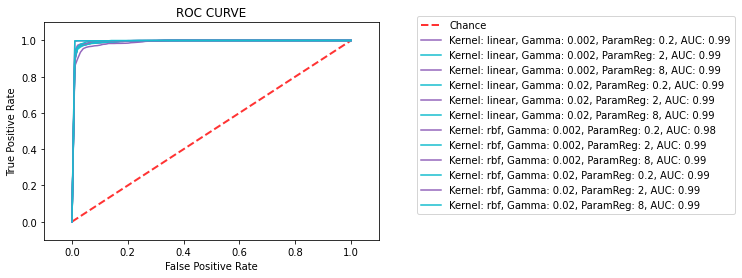

In [196]:
resultadosSVC=experimentar_SVC(X_res,y_res,kernels=['linear','rbf'],gammas = [0.002,0.02], params_reg = [0.2,2,8],extraccion=False)


In [197]:
resultadosSVC.sort_values(by=['Accuracy Test','Std Test'],ascending=False)

,kernel,gamma,Param reg,Accuracy Train,Std Train,Accuracy Test,Std Test,Vectores de soporte
11,rbf,0.020,8.0,0.995523,0.000480,0.990894,0.003555,8.203351
10,rbf,0.020,2.0,0.991624,0.000646,0.986563,0.002566,12.998267
8,rbf,0.002,8.0,0.976603,0.000646,0.971836,0.004797,17.562103
2,linear,0.002,8.0,0.971982,0.002104,0.966201,0.005262,8.911034
5,linear,0.020,8.0,0.971982,0.002104,0.966201,0.005262,8.911034
1,linear,0.002,2.0,0.970537,0.001473,0.964470,0.006760,9.315425
4,linear,0.020,2.0,0.970537,0.001473,0.964470,0.006760,9.315425
0,linear,0.002,0.2,0.969526,0.001703,0.963605,0.006244,11.770653
3,linear,0.020,0.2,0.969526,0.001703,0.963605,0.006244,11.770653
9,rbf,0.020,0.2,0.971260,0.001491,0.963597,0.005318,29.332756


# **Análisis de características individual**

**Correlación**

In [198]:
dfCorr=(df.drop(['NSP'],axis=1)).corr()

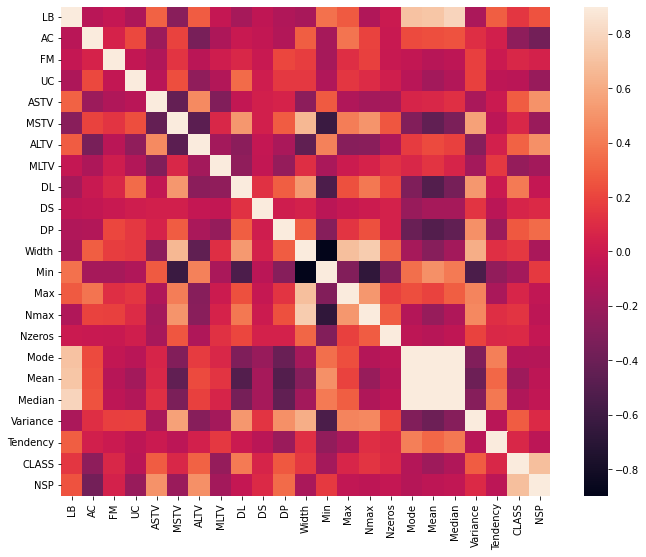

In [199]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True);

In [200]:
dfCorr

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS
LB,1.000000,-0.077967,-0.033305,-0.127722,0.305570,-0.279607,0.285630,-0.032091,-0.155908,-0.053518,-0.117133,-0.147679,0.361619,0.275110,-0.113933,-0.004745,0.708993,0.723121,0.789246,-0.133938,0.293503,0.143001
AC,-0.077967,1.000000,0.053956,0.212100,-0.197985,0.191378,-0.345162,-0.128901,-0.011350,-0.039341,-0.110317,0.291516,-0.157447,0.373493,0.191475,-0.011430,0.221693,0.236811,0.250729,0.111981,0.032235,-0.255205
FM,-0.033305,0.053956,1.000000,-0.036626,-0.116461,0.138061,-0.072214,0.021031,0.076283,-0.010328,0.205337,0.171448,-0.158422,0.111228,0.183904,-0.014632,-0.037492,-0.085718,-0.056281,0.177793,-0.000069,0.077805
UC,-0.127722,0.212100,-0.036626,1.000000,-0.079651,0.232687,-0.247513,-0.106590,0.339484,0.018405,0.152395,0.152990,-0.112597,0.146645,0.095512,0.022701,-0.077695,-0.169739,-0.111041,0.184188,-0.060995,-0.073465
ASTV,0.305570,-0.197985,-0.116461,-0.079651,1.000000,-0.430705,0.459413,-0.315105,-0.037040,0.033949,0.053677,-0.260463,0.275378,-0.111806,-0.167561,-0.149296,0.058363,0.074554,0.119960,-0.146434,-0.005748,0.284580
MSTV,-0.279607,0.191378,0.138061,0.232687,-0.430705,1.000000,-0.470259,0.073892,0.516901,0.034130,0.287548,0.660847,-0.622569,0.409072,0.501430,0.266183,-0.307586,-0.445401,-0.336109,0.555852,-0.066140,0.077214
ALTV,0.285630,-0.345162,-0.072214,-0.247513,0.459413,-0.470259,1.000000,-0.171114,-0.266298,-0.030770,-0.140133,-0.451297,0.422834,-0.283183,-0.279301,-0.121784,0.165211,0.222321,0.186480,-0.281536,0.042481,0.303050
MLTV,-0.032091,-0.128901,0.021031,-0.106590,-0.315105,0.073892,-0.171114,1.000000,-0.251442,-0.037667,-0.230849,0.110942,-0.144976,0.002023,0.056357,0.123869,0.072071,0.137813,0.063228,-0.164079,0.153093,-0.228310
DL,-0.155908,-0.011350,0.076283,0.339484,-0.037040,0.516901,-0.266298,-0.251442,1.000000,0.121617,0.294068,0.520656,-0.539125,0.242187,0.393860,0.208487,-0.315463,-0.509446,-0.353878,0.515130,-0.000687,0.395887
DS,-0.053518,-0.039341,-0.010328,0.018405,0.033949,0.034130,-0.030770,-0.037667,0.121617,1.000000,0.019766,0.044880,-0.071974,-0.021135,0.007024,0.043441,-0.215161,-0.158673,-0.160451,0.136421,-0.070483,0.060861


In [201]:
def findFeaturesWithCorrelationOf(dfCorre,umbral):
  for i in range(0,dfCorre.shape[0]):
    if sum(dfCorre.iloc[i]>umbral)+sum(dfCorre.iloc[i]<-umbral)>=2:
      print(dfCorre.iloc[i].name)
      return
  print("Con ese valor de correlación no hay ningún par de características.")
  return

In [202]:
findFeaturesWithCorrelationOf(dfCorr,0.9)

Mode


## **Índice de Fisher**

In [203]:
def fisher_index(X, plot=True):
  C = X.shape[1]
  indexes =np.zeros(X.shape[1])
  j = 0
  for i in range(C):
    if_j = 0
    for k in range(C):
      if i == k:
        continue
      mean_i = np.mean(X[:,i])
      mean_k = np.mean(X[:,k])
      std_i = np.std(X[:,i])
      std_k = np.std(X[:,k])

      if_j += ((mean_i - mean_k)**2 )/(std_i**2 + std_k**2)
    indexes[j] = if_j
    j += 1

  indexes = indexes / np.max(indexes)
  
  if plot == True:
    x = np.array(np.linspace(0, C, C))
    y = indexes
    plt.stem(x, y)
    plt.xlabel('Variables')
    plt.ylabel('Índice de fisher')
    plt.show()    
  return indexes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


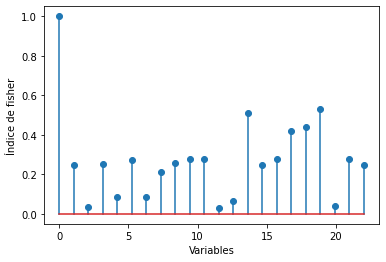

Index(['FM', 'Width', 'Variance'], dtype='object')

In [204]:
df.columns[np.argpartition(fisher_index(X),3)[:3]]

# **Selección de características**

In [205]:
def testingSFS(X,Y,num_ft):
  estimator= SVC(kernel="linear", C=1)
  sfs1 = SFS(estimator, 
            k_features=num_ft, 
            forward=True, 
            floating=False, 
            verbose=2,
            scoring='accuracy',
            cv=0)
  sfs1 = sfs1.fit(X_res, y_res)
  return sfs1  

In [206]:
sfs1=testingSFS(X_res,y_res,X_res.shape[1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   17.6s finished

[2021-10-12 03:24:33] Features: 1/22 -- score: 0.8505199306759099[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    6.6s finished

[2021-10-12 03:24:39] Features: 2/22 -- score: 0.9003466204506065[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.4s finished

[2021-10-12 03:24:47] Features: 3/22 -- score: 0.9185441941074524[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [207]:
pd.DataFrame.from_dict(sfs1.subsets_)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
feature_idx,"(21,)","(10, 21)","(6, 10, 21)","(6, 10, 12, 21)","(4, 6, 10, 12, 21)","(4, 6, 8, 10, 12, 21)","(1, 4, 6, 8, 10, 12, 21)","(1, 4, 6, 8, 10, 12, 14, 21)","(1, 4, 6, 8, 9, 10, 12, 14, 21)","(1, 3, 4, 6, 8, 9, 10, 12, 14, 21)","(1, 3, 4, 6, 8, 9, 10, 12, 14, 18, 21)","(1, 3, 4, 6, 8, 9, 10, 12, 14, 16, 18, 21)","(1, 3, 4, 6, 8, 9, 10, 11, 12, 14, 16, 18, 21)","(1, 3, 4, 6, 8, 9, 10, 11, 12, 14, 16, 18, 20,...","(1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18,...","(0, 1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ...","(0, 1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...","(0, 1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...","(0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
cv_scores,[0.8505199306759099],[0.9003466204506065],[0.9185441941074524],[0.92894280762565],[0.9397746967071057],[0.9436741767764298],[0.9545060658578857],[0.9597053726169844],[0.9623050259965338],[0.9644714038128249],[0.9657712305025996],[0.9692374350086655],[0.9709705372616985],[0.9718370883882149],[0.9718370883882149],[0.9709705372616985],[0.9709705372616985],[0.970103986135182],[0.9705372616984402],[0.9709705372616985],[0.9718370883882149],[0.9705372616984402]
avg_score,0.85052,0.900347,0.918544,0.928943,0.939775,0.943674,0.954506,0.959705,0.962305,0.964471,0.965771,0.969237,0.970971,0.971837,0.971837,0.970971,0.970971,0.970104,0.970537,0.970971,0.971837,0.970537
feature_names,"(21,)","(10, 21)","(6, 10, 21)","(6, 10, 12, 21)","(4, 6, 10, 12, 21)","(4, 6, 8, 10, 12, 21)","(1, 4, 6, 8, 10, 12, 21)","(1, 4, 6, 8, 10, 12, 14, 21)","(1, 4, 6, 8, 9, 10, 12, 14, 21)","(1, 3, 4, 6, 8, 9, 10, 12, 14, 21)","(1, 3, 4, 6, 8, 9, 10, 12, 14, 18, 21)","(1, 3, 4, 6, 8, 9, 10, 12, 14, 16, 18, 21)","(1, 3, 4, 6, 8, 9, 10, 11, 12, 14, 16, 18, 21)","(1, 3, 4, 6, 8, 9, 10, 11, 12, 14, 16, 18, 20,...","(1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18,...","(0, 1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ...","(0, 1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...","(0, 1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...","(0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [208]:
#Showing name of each column
indexSeleccion=[ 1,3, 4, 6,8, 10, 11, 12, 13, 14, 16, 20, 21]
for i in indexSeleccion:
  print(df.iloc[:,i].name)

AC
UC
ASTV
ALTV
DL
DP
Width
Min
Max
Nmax
Mode
Tendency
CLASS


In [209]:
#Se cambian los valores de X y Y con las caracteristicas seleccionadas:
indexSeleccion=[  1, 3, 4, 6, 8, 9, 10, 11, 12, 14, 16, 18, 20, 21,22]# 22 is the variable to predict

df.columns[indexSeleccion]
dfNew=df[df.columns[indexSeleccion]]

X,Y = Takex_y(dfNew)

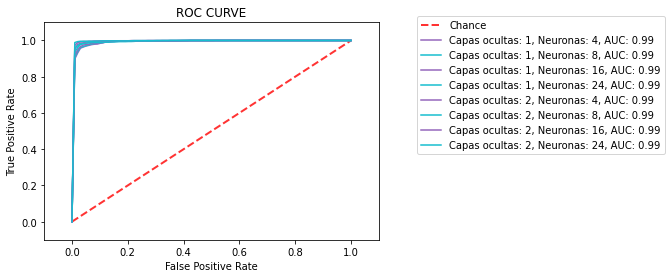

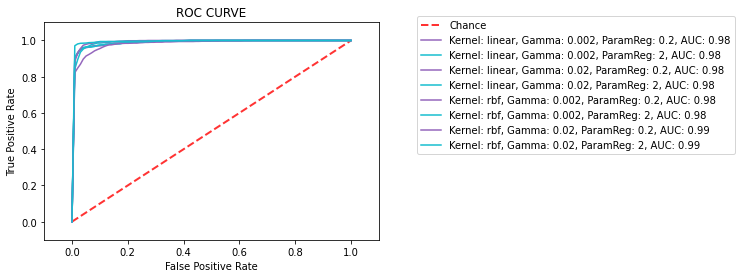

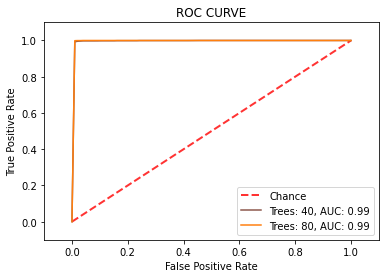

In [211]:
#Redes neuronales
resultadosMlp = experimentar_Mlp(X,Y, [1,2], [4,8,16,24],False)
#Maquinas de Soporte Vectorial
resultadosSVC=experimentar_SVC(X,Y,kernels=['linear','rbf'],gammas = [0.002,0.02], params_reg = [0.2,2],extraccion=False)
#Gradient Boosting Tree
resultadosGbt = experimentar_Gbt([40,80],X, Y, False)

**Extracción de características**

In [212]:
def entrenamiento_pca_ext_caracteristicas(n_comp, X, Y):
    Errores = np.ones(5)
    times = np.ones(5)
    j = 0
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        escalar = StandardScaler()
        X_train = escalar.fit_transform(X_train)
        X_test = escalar.transform(X_test)
 

        pca = PCA(n_components=n_comp)
        tiempo_i = time.time()
        X_train_pca = pca.fit_transform(X= X_train)
        X_test_pca = pca.transform(X = X_test)
        clf = SVC(kernel="linear", C=1)
        clf.fit(X=X_train_pca, y=y_train)
        tiempo_o = time.time()-tiempo_i
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca))
        times[j] = tiempo_o
        j+=1

    return np.mean(Errores), np.std(Errores), np.mean(times)

In [213]:
def experimentar_PCA(n_feats, X, Y):
    df = pd.DataFrame()
    idx = 0
    split_number = 5
    
    for f in n_feats:
    
        ERROR_VALIDACION, IC_STD_VALIDACION, T_EJECUCION = entrenamiento_pca_ext_caracteristicas(n_comp=f, X= X,Y= Y)
        df.loc[idx,'CON_SEL'] = 'SI'
        df.loc[idx,'NUM_VAR'] = X.shape[0]
        df.loc[idx, 'T_EJECUCION'] = T_EJECUCION
        df.loc[idx,'ERROR_VALIDACION'] = ERROR_VALIDACION
        df.loc[idx, 'IC_STD_VALIDACION'] = IC_STD_VALIDACION
        idx+=1
    return df

In [214]:
experimentar_PCA(n_feats=[2,3,5,7,10,12], X= X, Y = Y)

,CON_SEL,NUM_VAR,T_EJECUCION,ERROR_VALIDACION,IC_STD_VALIDACION
0,SI,2126.0,0.105014,0.767725,0.138292
1,SI,2126.0,0.069235,0.922875,0.042817
2,SI,2126.0,0.075127,0.912043,0.061618
3,SI,2126.0,0.057094,0.932746,0.035714
4,SI,2126.0,0.049035,0.935558,0.037579
5,SI,2126.0,0.032206,0.939316,0.044760


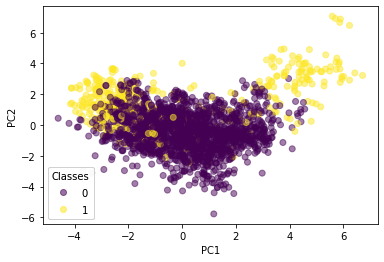

In [215]:
data_to_plot = StandardScaler().fit_transform(X=X)
fig, ax = plt.subplots()
pca = PCA(n_components=2)
x_pc2 = pca.fit_transform(data_to_plot)
scatter= ax.scatter(x= x_pc2[:,0], y = x_pc2[:,1], c = Y, alpha = 0.5, label = Y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

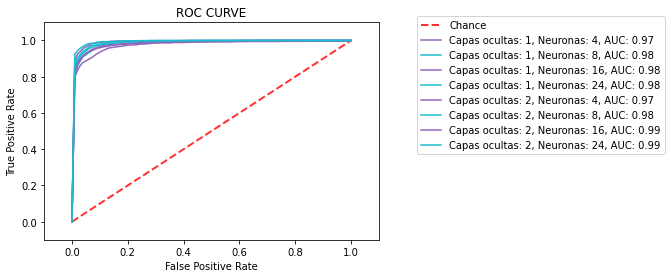

In [216]:
#Redes neuronales
resultadosMlp = experimentar_Mlp(X,Y, [1,2], [4,8,16,24],True)

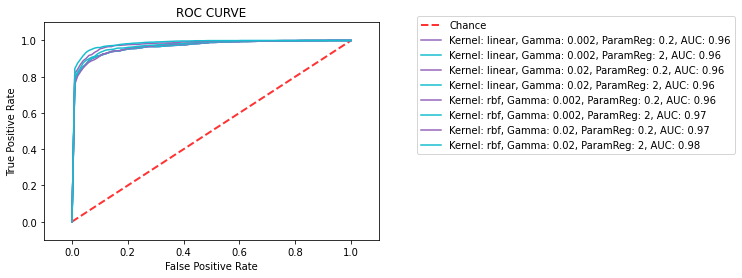

In [217]:
#Maquinas de Soporte Vectorial
resultadosSVC=experimentar_SVC(X,Y,kernels=['linear','rbf'],gammas = [0.002,0.02], params_reg = [0.2,2],extraccion=True)